<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-1/agent-memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agent 的记忆（Agent Memory）

## 回顾

在上一节中，我们构建了一个 Agent，它可以：

- `act`：让模型调用特定的工具。
- `observe`：将工具的输出返回给模型。
- `reason`：让模型基于工具输出进行推理，决定下一步（例如继续调用工具，或直接给出回复）。

![示意图](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## 本节目标

我们将为 Agent 引入“记忆”，让它能够在多轮对话与中断后继续上下文。

In [1]:
%%capture --no-stderr
# %pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt
%pip install --quiet langchain_openai==0.3.32 langchain_core==0.3.75 langgraph==0.6.7 langgraph-prebuilt==0.6.4

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


我们将使用 [LangSmith](https://docs.smith.langchain.com/) 进行[链路追踪（tracing）](https://docs.smith.langchain.com/concepts/tracing)，以便可视化与调试执行过程。

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY: ··········


下面的步骤与我们在上一节中所做的基本一致。

In [4]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """将 a 与 b 相乘。

    参数:
        a: 第一个整数
        b: 第二个整数
    """
    return a * b

# 该函数将注册为一个可被 Agent 调用的“工具”
def add(a: int, b: int) -> int:
    """将 a 与 b 相加。

    参数:
        a: 第一个整数
        b: 第二个整数
    """
    return a + b

def divide(a: int, b: int) -> float:
    """将 a 与 b 相除。

    参数:
        a: 第一个整数
        b: 第二个整数
    """
    return a / b

# 将工具列表绑定到模型实例上，使模型能够调用它们
tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

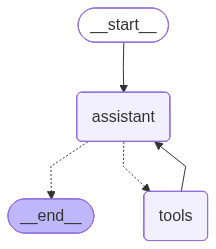

In [6]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# 构建图（Graph）
builder = StateGraph(MessagesState)

# 定义节点（Nodes）：实际执行工作的单元
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# 定义边（Edges）：决定控制流如何在节点间流转
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # 若 assistant 最新消息是工具调用 -> 由 tools_condition 路由到 tools
    # 若不是工具调用 -> 由 tools_condition 路由到 END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# 显示图结构
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## 记忆（Memory）

先像之前一样运行我们的 Agent。

In [7]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_AhQ30xmwEsYxXDgJ2wKk8KQk)
 Call ID: call_AhQ30xmwEsYxXDgJ2wKk8KQk
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


现在，把结果再乘以 2！

In [8]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

There seems to be a missing number or context here. Could you please specify what "that" is that needs to be multiplied by 2?


我们没有保留第一次对话中得到的 7！

这是因为在一次图（graph）执行中，[状态是瞬态的（transient）](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220)。

这会限制我们在多轮对话或有中断的场景下继续上下文。

解决办法是使用[持久化（persistence）](https://langchain-ai.github.io/langgraph/how-tos/persistence/)。

LangGraph 可以使用“检查点（checkpointer）”在每一步后自动保存图状态。

这个内置的持久化层为我们提供了“记忆”，使得 LangGraph 能从上一次的状态继续执行。

最易于上手的检查点实现是 `MemorySaver`：它在内存中以键值存储的方式保存图状态。

我们只需要在编译图时传入一个检查点实现，图就具备了记忆能力。

In [9]:
from langgraph.checkpoint.memory import MemorySaver
# 使用内存型检查点（MemorySaver）作为持久化后端
memory = MemorySaver()
# 编译图时传入检查点，使图具备“记忆”能力
react_graph_memory = builder.compile(checkpointer=memory)

当我们启用记忆时，需要指定一个 `thread_id`。

`thread_id` 用于标识并存储该会话的多次图状态快照。

示意说明：

- 检查点在图的每一步都会写入状态。
- 这些状态快照保存在某个“线程（thread）”中。
- 未来我们可以通过相同的 `thread_id` 访问并继续该线程。

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [10]:
# 指定线程（thread），用于归档该会话的状态
config = {"configurable": {"thread_id": "1"}}

# 指定输入消息
messages = [HumanMessage(content="Add 3 and 4.")]

# 运行，状态将被自动检查点保存
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_9xNe7XYX5FYWGbgFeDJ4cPd8)
 Call ID: call_9xNe7XYX5FYWGbgFeDJ4cPd8
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


如果我们传入相同的 `thread_id`，就可以从上一次保存的状态检查点继续！

在本例中，上面的对话已经被记录在该线程中。

我们现在追加一个 `HumanMessage`（内容为“Multiply that by 2.”），它会接在已有对话之后。

因此，模型能够理解此处的“that”（“那个”）指代上一步的结论 “The sum of 3 and 4 is 7.”。

In [11]:
# 在同一线程中继续对话，让模型利用先前的上下文
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_9xNe7XYX5FYWGbgFeDJ4cPd8)
 Call ID: call_9xNe7XYX5FYWGbgFeDJ4cPd8
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_j7aE27HXYUCOi1PXjUhO27bv)
 Call ID: call_j7aE27HXYUCOi1PXjUhO27bv
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

## LangGraph Studio


**⚠️ 说明**

自视频录制以来，Studio 已更新为支持本地运行并在浏览器中打开。推荐使用本地开发服务器（而非视频中展示的桌面应用）。你可以参考以下文档了解更多：[本地开发服务器](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) 与 [如何启动本地 Studio](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。要在本模块的 `module-1/studio/` 目录中启动本地开发服务器，请在终端运行：

```
langgraph dev
```